## Description:

* Perform open-ended EDA

In [1]:
'''Helper'''
import pandas as pd
import numpy as np
import datetime
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

DATA_PATH = '/home/jupyter/bi-competitor-analysis/data/'
# pd.set_option('max_colwidth', 800)

#### Data Observations:

* Data contains 79k+ tweets from 16-Feb-2021 till 6-May-2021 i.e. almost 90 days
* Data contains 16 handles
* A tweet id can be pulled multiple times. Therefore, keep only latest data for each tweet id - based on max(pulled_at)
* Tweets can be incomplete
* Almost every tweet contains URL to actual publisher article

**Cleaning**:
* Remove mentions (@handle-name)
* Replace contractions with their full forms
* Remove any URLs present in tweets
* Remove punctuations and numbers
* Lowercase
* Replace any emojis or emoticons with the text they represent - as they play an imp role in representing a sentiment
* Remove tweets with less than or equal to 3 words and drop duplicates
* Add new columns - num_emojis, hashtags and num_hashtags

Note: Cleaned tweets present in column "clean_text"

In [2]:
df = pd.read_csv(DATA_PATH + "twt_main_cleaned.csv")
df.id = df.id.astype(str)

* Twitter API returns times in UTC. Convert that to EST

In [3]:
df.created_at = pd.to_datetime(df.created_at)
# convert to EST
df['created_at_est'] = df['created_at'].dt.tz_convert('US/Eastern')

# extract date
df['created_date'] = df.created_at_est.dt.date
df.created_date = pd.to_datetime(df.created_date)

# extract hour
df['created_hour'] = [datetime.datetime.time(d).hour for d in df['created_at_est']]

# extract dow
df['dow'] = df.created_date.dt.day_name()

In [4]:
print(df.shape)
df.head(2)

(79504, 19)


,created_at,handle,id,text,url,retweet_cnt,like_cnt,reply_cnt,is_rt,pulled_at,num_emojis,hashtags,num_hashtags,clean_text,clean_txt_len,created_at_est,created_date,created_hour,dow
0,2021-02-27 23:14:05+00:00,nytimes,1365802415371522049,Breaking News: The FDA authorized Johnson &amp...,https://nyti.ms/2Mz4Y9m,6279,16747,880,False,2021-02-28 14:00:30.16545 UTC,0,[],0,breaking news the fda authorized johnson johns...,23,2021-02-27 18:14:05-05:00,2021-02-27,18,Saturday
1,2021-04-09 16:29:10+00:00,nytimes,1380558416268120064,"Breaking News: DMX, the snarling yet soulful r...",https://nyti.ms/3204AVt,6161,14010,425,False,2021-04-09 18:00:29.546092 UTC,0,[],0,breaking news dmx the snarling yet soulful rap...,23,2021-04-09 12:29:10-04:00,2021-04-09,12,Friday


### EDA

**Observation:**
* Forbes posts the 2nd most - just under Bloomberg business
* In terms of likes and replies Forbes is below NYT and Washington Post - despite those 2 posting far less

In [5]:
# Most tweets by handle

pd.DataFrame(
    df.groupby('handle').id.count() \
        .sort_values(ascending=False)) \
            .rename(columns={'id':'tweet_cnt'}
           )

,tweet_cnt
handle,
business,16215
forbes,8378
nytimes,7746
washingtonpost,6380
theeconomist,6377
businessinsider,5853
wsj,5741
axios,5176
reutersbiz,4967


In [6]:
# Most retweets, likes, replies by handle

df[['handle', 'retweet_cnt', 'like_cnt', 'reply_cnt']].groupby('handle').sum() \
    .sort_values(
        by='like_cnt',
        ascending=False
    )

,retweet_cnt,like_cnt,reply_cnt
handle,,,
nytimes,778206,2574288,271331
washingtonpost,422070,1527562,294068
forbes,147084,577418,65228
business,281986,548428,73529
axios,172048,492241,67548
wsj,154940,486790,81531
theeconomist,135911,387376,43541
businessinsider,132263,262870,17232
wired,60043,177931,9327


**Observation:**
* Avg. likes, retweets, replies per tweet for Forbes is lesser than nyt, washington post, axios, wsj, wired, bi, economist, foxbusiness

In [7]:
# Most avg. likes by handle

df[['handle', 'retweet_cnt', 'like_cnt', 'reply_cnt']].groupby('handle').mean() \
    .sort_values(
        by='like_cnt',
        ascending=False
    ).astype(int)

,retweet_cnt,like_cnt,reply_cnt
handle,,,
nytimes,100,332,35
washingtonpost,66,239,46
axios,33,95,13
wsj,26,84,14
wired,24,71,3
forbes,17,68,7
theeconomist,21,60,6
foxbusiness,14,45,15
businessinsider,22,44,2


**Observation:**
* Likes and retweets are strongly (positively) correlated
* Replies are loosely (positively) correlated to likes and retweets
* Number of emojis or hashtags has no correlation with engagement metrics

In [8]:
corr=df[['retweet_cnt', 'like_cnt', 'reply_cnt', 'num_emojis', 'num_hashtags']].corr()

corr.style.background_gradient(cmap='RdPu')

,retweet_cnt,like_cnt,reply_cnt,num_emojis,num_hashtags
retweet_cnt,1.000000,0.758370,0.386632,-0.004302,-0.010409
like_cnt,0.758370,1.000000,0.469715,-0.008825,-0.009188
reply_cnt,0.386632,0.469715,1.000000,-0.010018,-0.022463
num_emojis,-0.004302,-0.008825,-0.010018,1.000000,0.016586
num_hashtags,-0.010409,-0.009188,-0.022463,0.016586,1.000000


**TODO:**
* Check if presence of particular hashtag, results in engagement 
    * POTENTIAL USE: present to team that using particular hashtags maybe beneficial 
        * Useful?
        
## Competitor analysis 

In [9]:
def get_top_n_words(corpus, n=None):
    '''
    Inputs:
        corpus - array of tweets
        n - top n words required
    
    Output:
        top-n-words
    '''
    vec = CountVectorizer(ngram_range=(2, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

def call_top_n_words(publisher):
    '''
    call get_top_n_words for each publisher input
    '''
    return pd.DataFrame(get_top_n_words(df[df.handle ==publisher]['clean_text'], 25), columns = ['trigram' , 'count'])

In [10]:
# make dataframe containing top n n-grams for each publisher: so that we get an idea of themes they write about

nyt_df = call_top_n_words('nytimes')
bi_df = call_top_n_words('businessinsider')
forbes_df = call_top_n_words('forbes')
wired_df = call_top_n_words('wired')
wsj_df = call_top_n_words('wsj')
axios_df = call_top_n_words('axios')
apbusiness_df = call_top_n_words('apbusiness')
financialtimes_df = call_top_n_words('financialtimes')
business_df = call_top_n_words('business')
washingtonpost_df = call_top_n_words('washingtonpost')
cnnbusiness_df = call_top_n_words('cnnbusiness')
foxbusiness_df = call_top_n_words('foxbusiness')
reutersbiz_df = call_top_n_words('reutersbiz')
theeconomist_df = call_top_n_words('theeconomist')
inc_df = call_top_n_words('inc')
entrepreneur_df = call_top_n_words('entrepreneur')

### Most frequent N-grams (bi- and tri-grams) per competitor 

* **conclusion:** can group competitors for manageable analysis

    * More business focused competitors = 
        * 'businessinsider', 'cnnbusiness', 'foxbusiness', 'reutersbiz', 'financialtimes', 'bloomberg-business' 
    * More news/current affairs focused competitors = 
        * 'nytimes', 'wsj', 'washingtonpost', 'axios', 'apbusiness', 'theeconomist'
    * More tech/enterpreneur focused = 
        * 'inc', 'wired', 'entrepreneur'

Example: In finance, individual company's financials are compared against a group of its peers's financials (like GE financials vs S&P500) <br>

**Note-** cons: individual engagement may get obscured

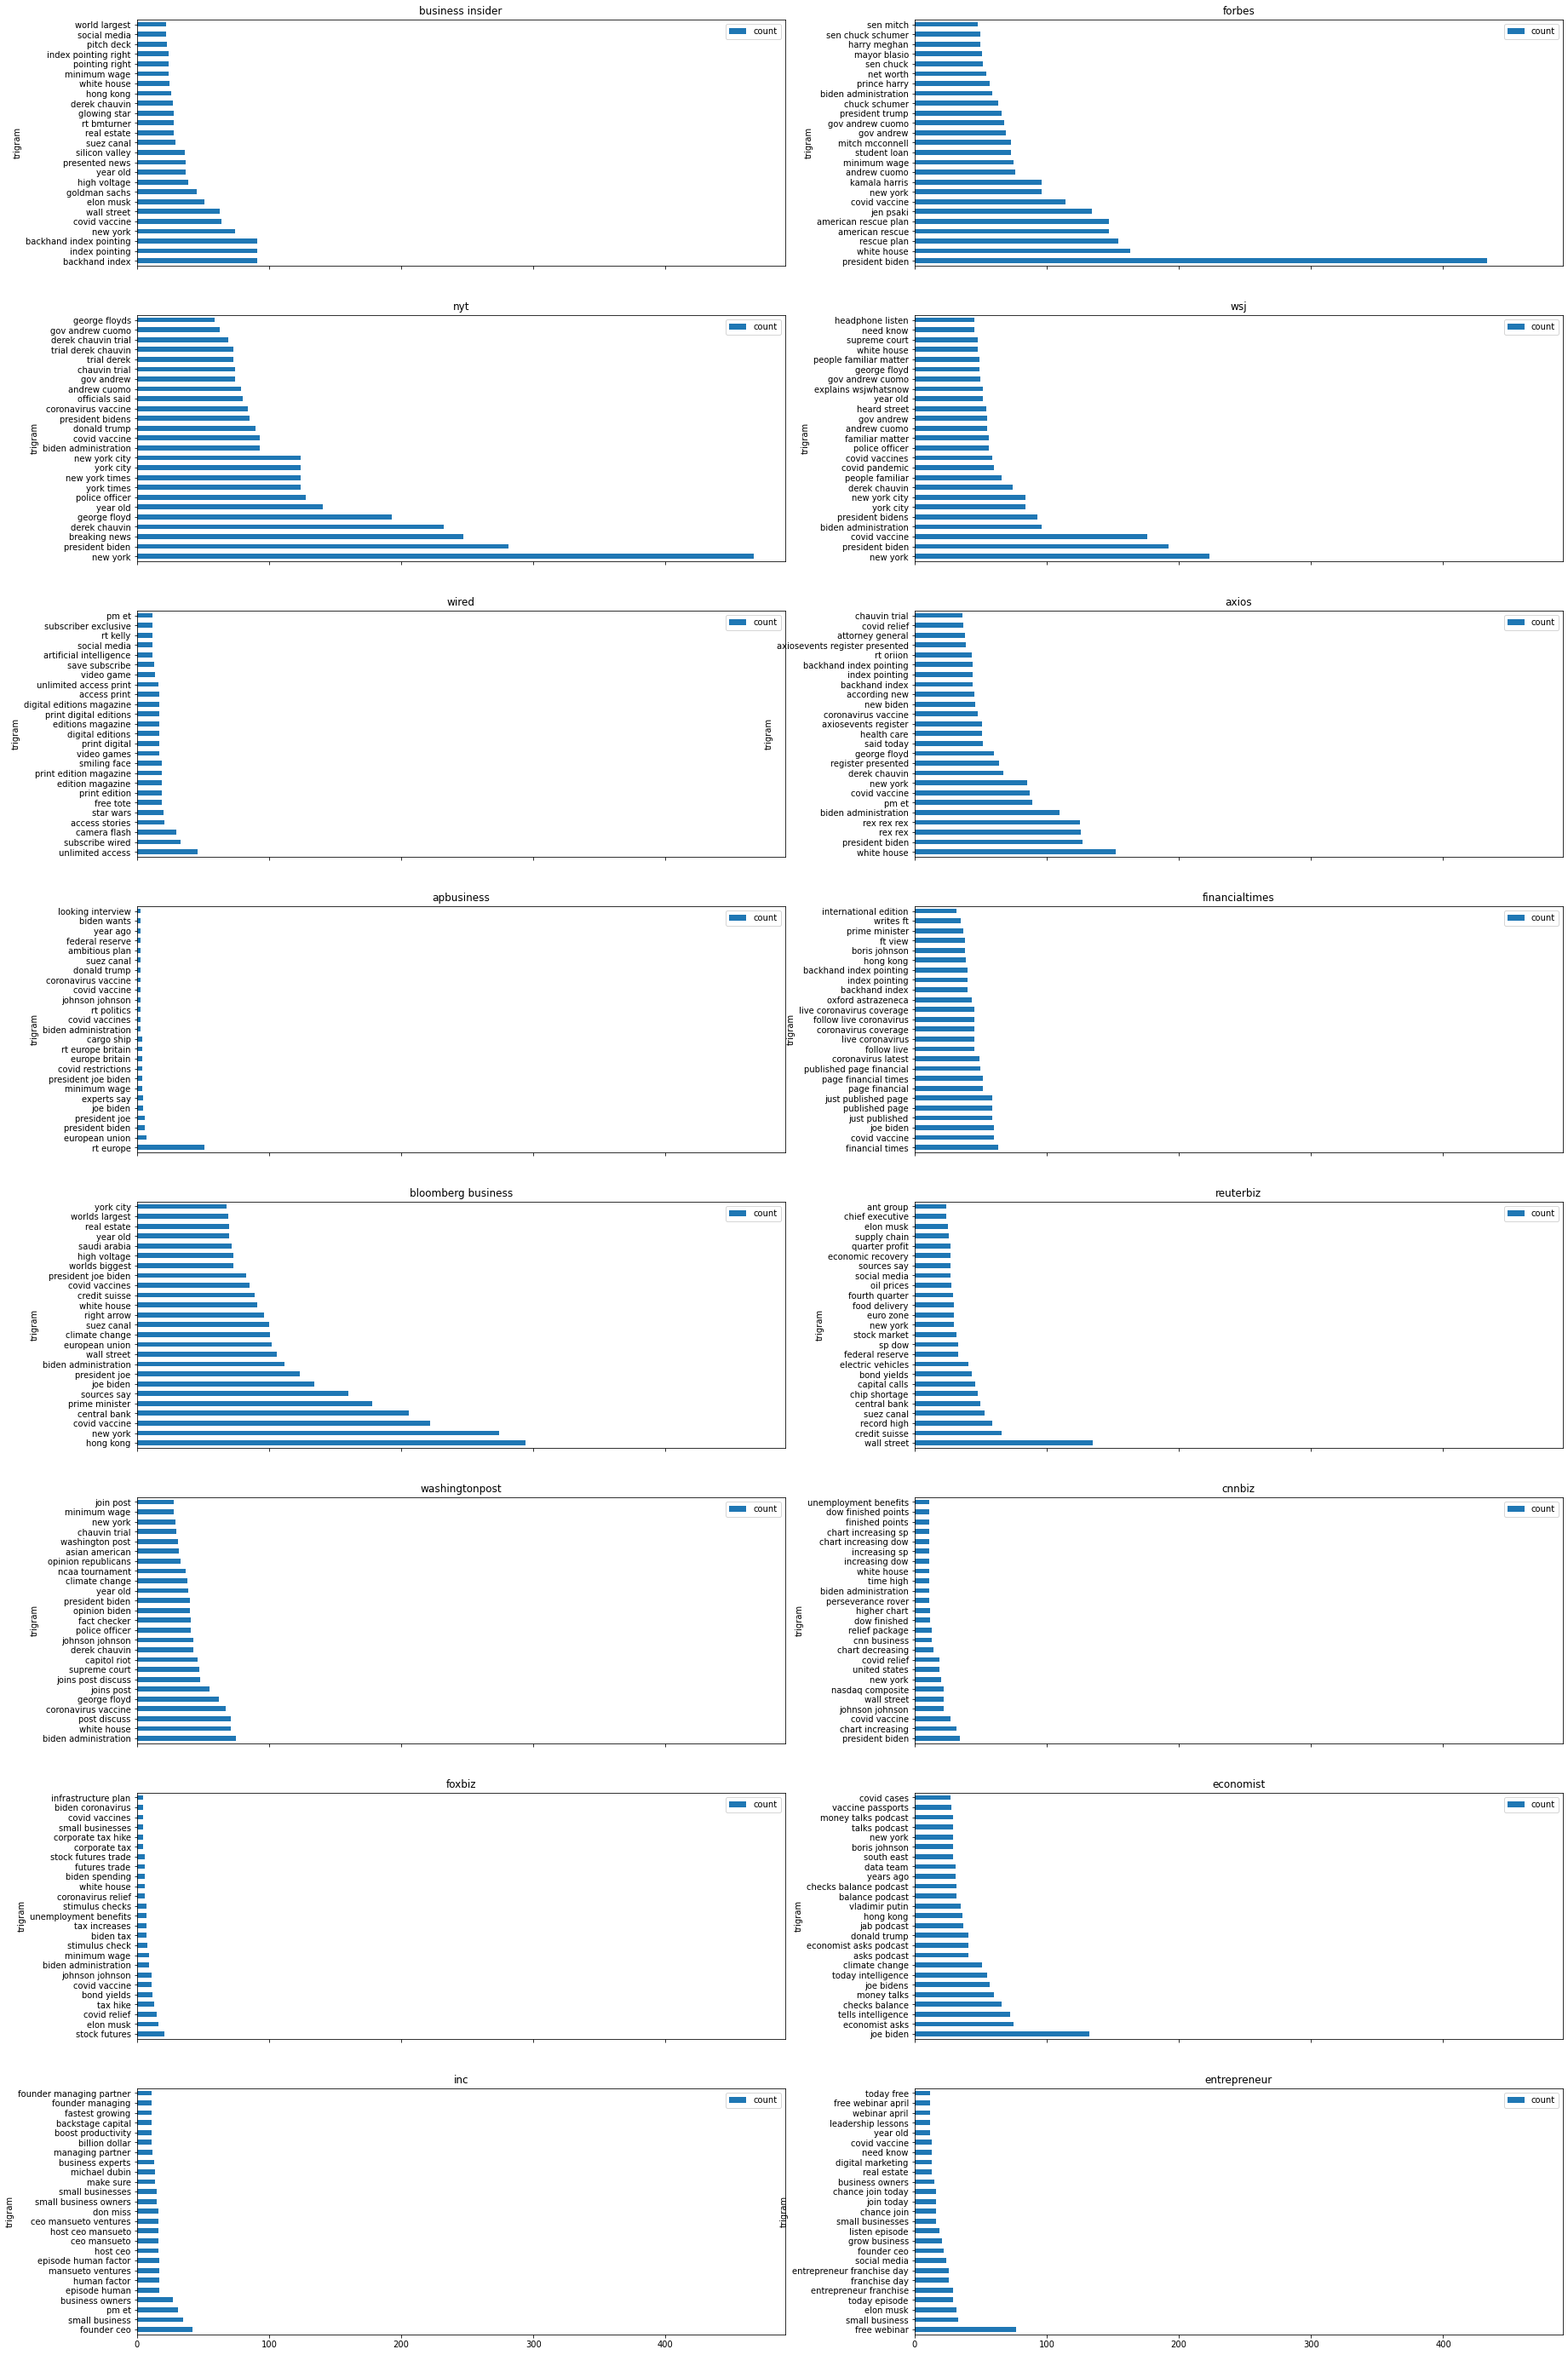

In [12]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(30,50), sharex=True)

forbes_df.plot(x="trigram", y="count", kind="barh", ax = axes[0][1], title = "forbes")
bi_df.plot(x="trigram", y="count", kind="barh", ax = axes[0][0], title = "business insider")  

nyt_df.plot(x="trigram", y="count", kind="barh", ax = axes[1][0], title = "nyt")
wsj_df.plot(x="trigram", y="count", kind="barh", ax = axes[1][1], title = "wsj")  

wired_df.plot(x="trigram", y="count", kind="barh", ax = axes[2][0], title = "wired")  
axios_df.plot(x="trigram", y="count", kind="barh", ax = axes[2][1], title = "axios")

apbusiness_df.plot(x="trigram", y="count", kind="barh", ax = axes[3][0], title = "apbusiness")  
financialtimes_df.plot(x="trigram", y="count", kind="barh", ax = axes[3][1], title = "financialtimes")

business_df.plot(x="trigram", y="count", kind="barh", ax = axes[4][0], title = "bloomberg business")  
reutersbiz_df.plot(x="trigram", y="count", kind="barh", ax = axes[4][1], title = "reuterbiz")

washingtonpost_df.plot(x="trigram", y="count", kind="barh", ax = axes[5][0], title = "washingtonpost")  
cnnbusiness_df.plot(x="trigram", y="count", kind="barh", ax = axes[5][1], title = "cnnbiz")

foxbusiness_df.plot(x="trigram", y="count", kind="barh", ax = axes[6][0], title = "foxbiz")  
theeconomist_df.plot(x="trigram", y="count", kind="barh", ax = axes[6][1], title = "economist")

inc_df.plot(x="trigram", y="count", kind="barh", ax = axes[7][0], title = "inc")  
entrepreneur_df.plot(x="trigram", y="count", kind="barh", ax = axes[7][1], title = "entrepreneur")

plt.show()

In [13]:
forbes_df = df[df.handle =='forbes']
print("forbes shape:", forbes_df.shape)
print()

busi_comp_df = df[df.handle.isin(['businessinsider', 'cnnbusiness', 'foxbusiness', 
                                  'reutersbiz', 'financialtimes', 'business'])]
print("business competitors shape:", busi_comp_df.shape)
print()

news_comp_df = df[df.handle.isin(['nytimes', 'wsj', 'washingtonpost', 'axios', 'apbusiness', 'theeconomist'])]
print("news/current affair competitors shape:", news_comp_df.shape)
print()

tech_comp_df = df[df.handle.isin(['inc', 'wired', 'entrepreneur'])]
print("tech competitors shape:", tech_comp_df.shape)

forbes shape: (8378, 19)

business competitors shape: (32464, 19)

news/current affair competitors shape: (31677, 19)

tech competitors shape: (6985, 19)


* **Num of tweets created by hour**
    * **TODO:**
        * Check engagement by hour

<AxesSubplot:title={'center':'Tech Competitors'}>

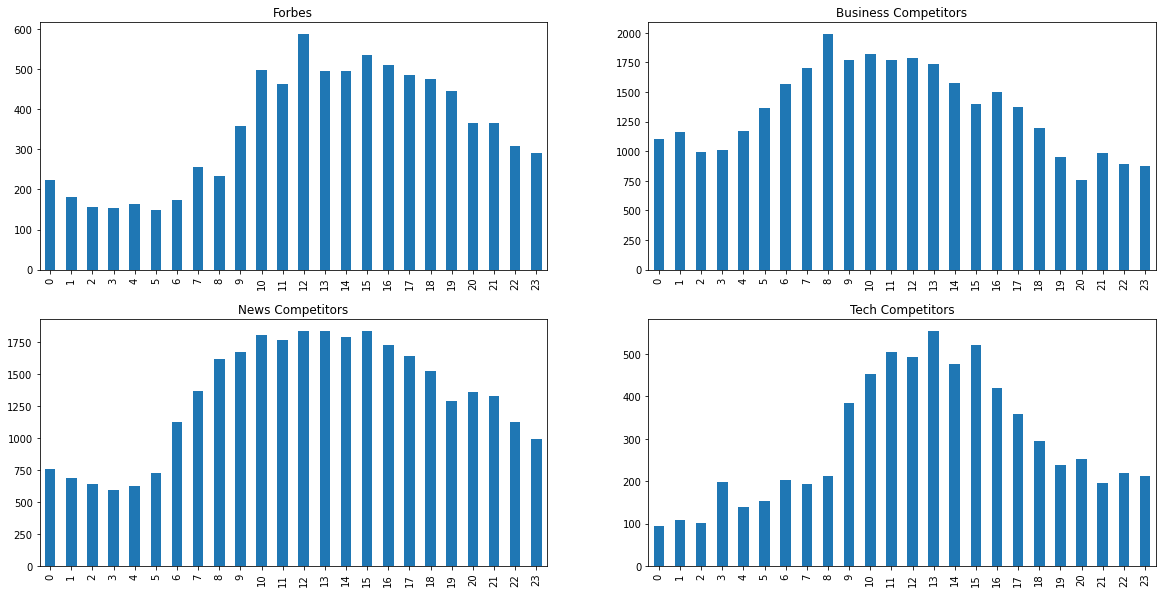

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10)) 

forbes_df.created_hour.value_counts().sort_index().plot(kind='bar', 
                                                        ax = axes[0][0], 
                                                        title="Forbes")
busi_comp_df.created_hour.value_counts().sort_index().plot(kind='bar', 
                                                           ax = axes[0][1], 
                                                           title="Business Competitors")
news_comp_df.created_hour.value_counts().sort_index().plot(kind='bar', 
                                                           ax = axes[1][0], 
                                                           title="News Competitors")
tech_comp_df.created_hour.value_counts().sort_index().plot(kind='bar', 
                                                           ax = axes[1][1], 
                                                           title="Tech Competitors")

* **Num of tweets created by day-of-week**
* POTENTIAL USE: If the goal is to get more engagement (assuming twitter engagement leads to pvs), post more on Tues
    * **Observation:**
        * For Forbes, Tues is the 3rd largest engagement day but we dont post as much on that day - may post more. Our business competitors post a lot on Tuesdays and its their highest engagement day

Why tweet the most on Wednesday? - double check

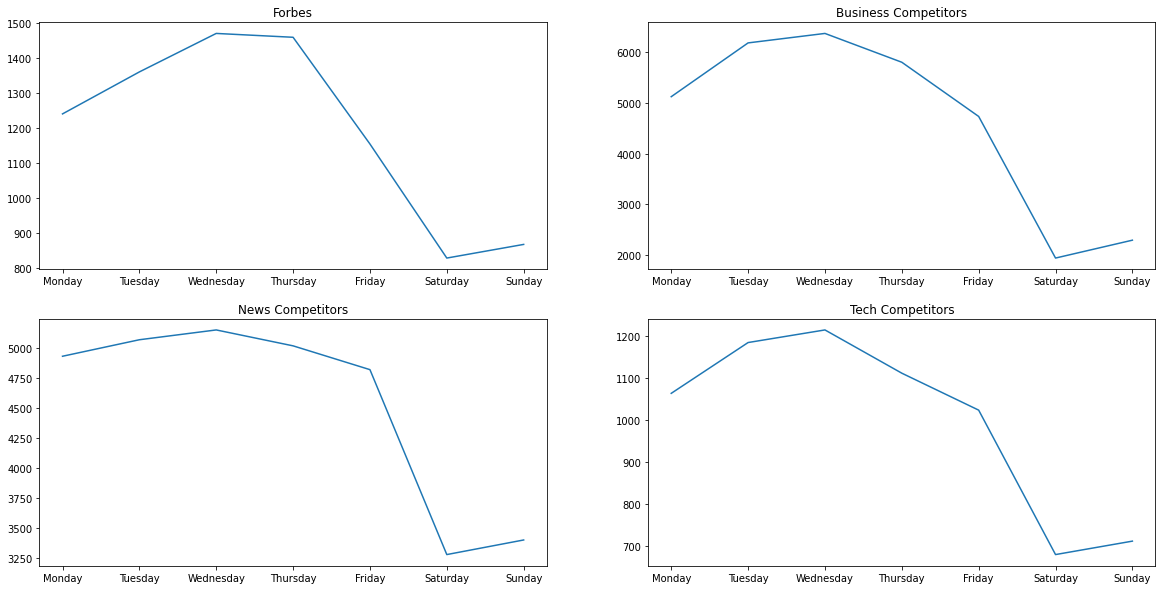

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10)) 

idx_reshuffle = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

forbes_df.dow.value_counts()[idx_reshuffle].plot(kind='line', 
                                                 ax = axes[0][0], 
                                                 title="Forbes")
busi_comp_df.dow.value_counts()[idx_reshuffle].plot(kind='line', 
                                                    ax = axes[0][1], 
                                                    title="Business Competitors")
news_comp_df.dow.value_counts()[idx_reshuffle].plot(kind='line', 
                                                    ax = axes[1][0], 
                                                    title="News Competitors")
tech_comp_df.dow.value_counts()[idx_reshuffle].plot(kind='line', 
                                                    ax = axes[1][1], 
                                                    title="Tech Competitors")
plt.show()

In [10]:
forbes_df.groupby("dow").agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum'}).sort_values('like_cnt', ascending=False)

,retweet_cnt,like_cnt,reply_cnt
dow,,,
Thursday,24003,98861,10567
Wednesday,25922,94607,10636
Tuesday,20819,84432,9547
Monday,21446,82897,8797
Sunday,18182,75299,9487
Friday,19082,72272,8451
Saturday,17630,69050,7743


In [11]:
busi_comp_df.groupby("dow").agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum'}).sort_values('like_cnt', ascending=False)

,retweet_cnt,like_cnt,reply_cnt
dow,,,
Tuesday,90604,175017,20467
Monday,84900,173919,19188
Wednesday,91943,173516,21242
Thursday,76145,146757,19129
Friday,70608,146000,17245
Sunday,61282,126187,12730
Saturday,50984,116013,11213


In [12]:
news_comp_df.groupby("dow").agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum'}).sort_values('like_cnt', ascending=False)

,retweet_cnt,like_cnt,reply_cnt
dow,,,
Monday,264589,906357,124244
Tuesday,288972,900213,125898
Wednesday,281186,859895,123032
Sunday,194019,753662,87960
Thursday,239077,739537,109775
Friday,240139,738752,102393
Saturday,180628,572748,85094


In [13]:
tech_comp_df.groupby("dow").agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum'}).sort_values('like_cnt', ascending=False)

,retweet_cnt,like_cnt,reply_cnt
dow,,,
Sunday,15161,56021,2096
Saturday,14368,54776,1980
Tuesday,19316,39610,2149
Monday,13991,38972,2415
Friday,15276,34581,2007
Thursday,11411,31499,2128
Wednesday,12131,30500,1950
